In [ ]:
import lightgbm as lgb
import numpy as np
from binary_io import *

dataset = 'imagenet'
dataset = 'wikipedia'
dataset = 'gist1m'
M = 128
efc = 1000
efs = 3000
ck_ts = 2000
k = 1000

data_prefix = '/data/guohaoran/HNNS/sample/'
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}'

train_feature = fvecs_read(f'{data_prefix}{prefix}.train_feats_nn.fvecs')
train_label = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 0]
test_feature = fvecs_read(f'{data_prefix}{prefix}.test_feats_nn.fvecs')
test_label = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 0]

# train_feature = train_feature[:, -100:]
# test_feature = test_feature[:, -100:]
print(len(train_feature), len(train_label))
print(np.sum(test_label), np.sum(train_label))
print(len(train_feature[0]), train_feature[0][-101:])
# train_feature = train_feature[:, :-3]
# test_feature = test_feature[:, :-3]

500000 500000
2958 152395
1127 [-5.4871583e-01 -5.4835093e-01 -5.4322875e-01 -5.4217482e-01
 -5.4200363e-01 -5.4169309e-01 -5.3889990e-01 -5.3769362e-01
 -5.3708905e-01 -5.3401315e-01 -5.3391588e-01 -5.3104347e-01
 -5.2990764e-01 -5.2754891e-01 -5.2667642e-01 -5.2471501e-01
 -5.2319968e-01 -5.2195871e-01 -5.2177465e-01 -5.2137613e-01
 -5.2085996e-01 -5.1989025e-01 -5.1947773e-01 -5.1858056e-01
 -5.1826596e-01 -5.1746380e-01 -5.1715970e-01 -5.1681602e-01
 -5.1669610e-01 -5.1560658e-01 -5.1284826e-01 -5.1233822e-01
 -5.1121199e-01 -5.1075327e-01 -5.1005000e-01 -5.0908983e-01
 -5.0818384e-01 -5.0756598e-01 -5.0740272e-01 -5.0691897e-01
 -5.0679356e-01 -5.0661975e-01 -5.0552666e-01 -5.0548923e-01
 -5.0534809e-01 -5.0446594e-01 -5.0407141e-01 -5.0309968e-01
 -5.0301677e-01 -5.0040203e-01 -5.0036317e-01 -4.9792784e-01
 -4.9692726e-01 -4.9667871e-01 -4.9667478e-01 -4.9656153e-01
 -4.9648234e-01 -4.9634403e-01 -4.9610615e-01 -4.9579066e-01
 -4.9561357e-01 -4.9560732e-01 -4.9554312e-01 -4.95470

In [6]:
params = {
    'boosting_type': 'gbdt',    # 使用 GBDT 算法
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss',            # 使用 binary_logloss 作为评估指标
    'learning_rate': 0.05,       # 学习率
    'num_boost_round': 3000,     # 提升迭代的轮数
    'verbose': 1,               # 控制处理信息的详细程度
    'num_threads': 128           # 设置线程数
}

In [7]:
gbm = lgb.train(params, lgb.Dataset(train_feature, label=train_label))

/home/zhengweiguo/miniconda3/envs/lcj_bert/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 152395, number of negative: 347605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287373
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 1127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304790 -> initscore=-0.824591
[LightGBM] [Info] Start training from score -0.824591


Area Under the Curve (AUC): 0.7702974983096686
0%->bruteforce | predict recall: 0.000000 | overall recall: 0.994084
2%->bruteforce | predict recall: 0.066599 | overall recall: 0.994478
4%->bruteforce | predict recall: 0.131846 | overall recall: 0.994864
6%->bruteforce | predict recall: 0.195740 | overall recall: 0.995242
8%->bruteforce | predict recall: 0.254564 | overall recall: 0.995590
10%->bruteforce | predict recall: 0.311359 | overall recall: 0.995926
12%->bruteforce | predict recall: 0.360717 | overall recall: 0.996218
14%->bruteforce | predict recall: 0.411427 | overall recall: 0.996518
16%->bruteforce | predict recall: 0.460784 | overall recall: 0.996810
18%->bruteforce | predict recall: 0.504733 | overall recall: 0.997070
20%->bruteforce | predict recall: 0.546315 | overall recall: 0.997316
22%->bruteforce | predict recall: 0.583502 | overall recall: 0.997536
24%->bruteforce | predict recall: 0.619675 | overall recall: 0.997750
26%->bruteforce | predict recall: 0.654834 | ove

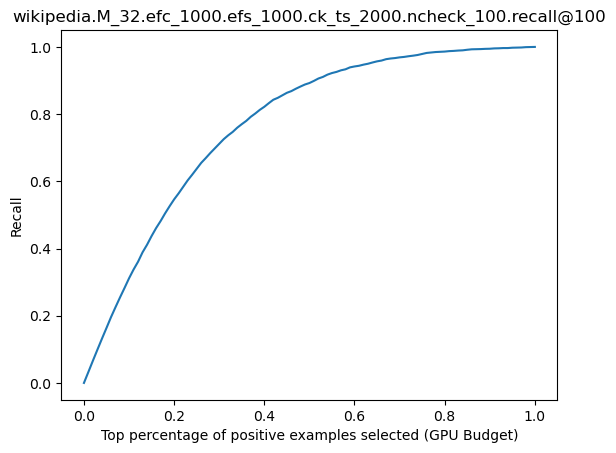

In [8]:
from sklearn.metrics import recall_score
import time
start = time.time()
label_pred = gbm.predict(test_feature)
end = time.time()

import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz

def recall_curve(test_label, label_pred):
    n = len(label_pred)
    recalls = []
    percentages = np.arange(0, 1.01, 0.01)  # 从0%到100%，步长为1%
    for p in percentages:
        threshold = np.percentile(label_pred, 100 * (1 - p))
        if p==0: threshold += 1
        new_label_pred = np.where(label_pred >= threshold, 1, 0)
        recall = recall_score(test_label, new_label_pred)
        recalls.append(recall)
    return percentages, recalls

percentages, recalls = recall_curve(test_label, label_pred)
auc = trapz(recalls, percentages)
print("Area Under the Curve (AUC):", auc)

total_true_label = np.sum(test_label)
step = 2
for p in range(0, 100 + step, step):
    fail = total_true_label * (1 - recalls[p])
    success = len(test_label) - fail
    overall_recall = (success * 1.000 + fail * 0.98) / len(test_label)
    print(f'{p}%->bruteforce | predict recall: {recalls[p]:4f} | overall recall: {overall_recall:6f}')

plt.plot(percentages, recalls)
plt.xlabel("Top percentage of positive examples selected (GPU Budget)")
plt.ylabel("Recall")

plt.title(f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}')
plt.savefig(f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.png')
plt.show()

# recall = recall_score(test_label, label_pred.round())
# print("Recall:", recall)